# Exploring collected Chart Data

In [97]:
import pandas as pd
from helpers.data import (
    create_data_path,
)
from helpers.spotify_util import (
    create_spotipy_client,
)
import os
from tqdm import tqdm
from datetime import date

data_folder = create_data_path("top200_2017-01_to_2023-06")
spotify = create_spotipy_client() # will be used later to verify/validate data we collected

In [98]:
charts_path = os.path.join(data_folder, "charts.parquet")
charts = pd.read_parquet(charts_path)
charts.head()

,date,region_code,track_id,pos,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams
0,2017-01-01,AR,6mICuAdrwEjh6Y6lroV2Kg,1,"Shakira, Maluma",Chantaje (feat. Maluma),Sony Music Latin,1,-1,1,253019
1,2017-01-01,AR,7DM4BPaS7uofFul3ywMe46,2,"Ricky Martin, Maluma",Vente Pa' Ca (feat. Maluma),Sony Music Latin,2,-1,1,223988
2,2017-01-01,AR,3AEZUABDXNtecAOSC1qTfo,3,CNCO,Reggaetón Lento (Bailemos),Sony Music Latin,3,-1,1,210943
3,2017-01-01,AR,6rQSrBHf7HlZjtcMZ4S4bO,4,"J Balvin, Pharrell Williams, BIA, Sky Rompiendo",Safari,UMLE - Latino,4,-1,1,173865
4,2017-01-01,AR,58IL315gMSTD37DOZPJ2hf,5,Daddy Yankee,Shaky Shaky,El Cartel Records (EC3),5,-1,1,153956


In [99]:
charts.track_id.nunique()

163454

In [100]:
charts.dtypes

date             datetime64[ns]
region_code              object
track_id                 object
pos                       int64
artist_names             object
track_name               object
source                   object
peak_rank                 int64
previous_rank             int64
days_on_chart             int64
streams                   int64
dtype: object

### Exploring Data Completeness by Region

In [101]:
region_chart_entry_counts = (
    charts.groupby("region_code").size().sort_values(ascending=False)
)
region_chart_entry_counts

region_code
FR    474390
PL    474390
IE    474389
BE    474389
GB    474389
       ...  
BY     99198
KZ     99155
VE     92000
PK     80878
LU     77692
Length: 73, dtype: int64

<Axes: title={'center': 'Number of chart entries per region'}, xlabel='region_code'>

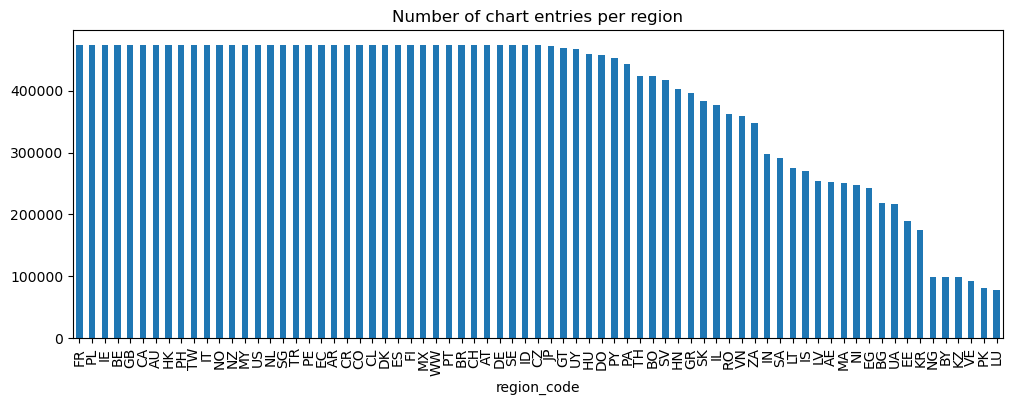

In [102]:
region_chart_entry_counts.plot.bar(figsize=(12, 4), title="Number of chart entries per region")

Looks like data completeness is good for most of the countries :)

It can happen that _some_ chart entries happen for a particular day. But it would be more annoying if data were missing for a few days completely. How often is that the case for what regions?

In [103]:
ideal_day_count = (charts.date.max() - charts.date.min()).days + 1
ideal_day_count

2372

<Axes: title={'center': 'Number of days with chart data by region'}, xlabel='region_code'>

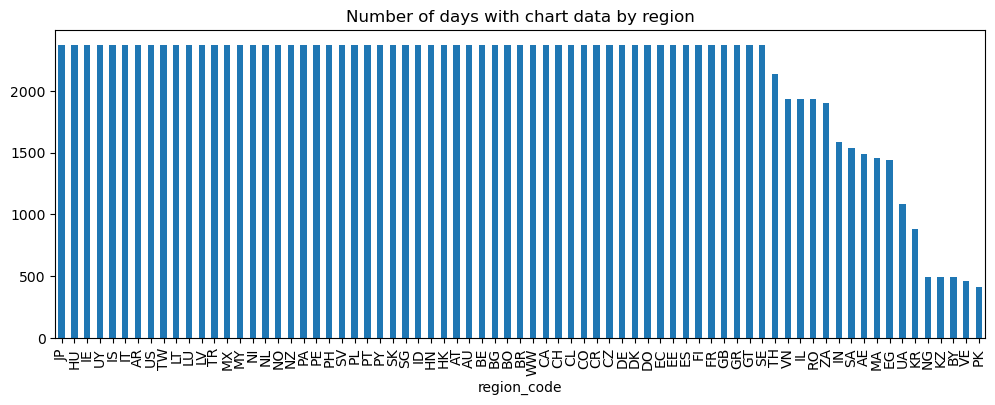

In [104]:
days_with_data_by_region = charts.groupby("region_code").date.nunique().sort_values(ascending=False)
days_with_data_by_region.plot.bar(figsize=(12, 4), title="Number of days with chart data by region")

How many regions are there where data exists for every single day since data is available in our dataset?

In [105]:
regions_with_data_for_every_day = days_with_data_by_region[days_with_data_by_region / ideal_day_count == 1].index
regions_with_data_for_every_day

Index(['JP', 'HU', 'IE', 'UY', 'IS', 'IT', 'AR', 'US', 'TW', 'LT', 'LU', 'LV',
       'TR', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'PA', 'PE', 'PH', 'SV', 'PL',
       'PT', 'PY', 'SK', 'SG', 'ID', 'HN', 'HK', 'AT', 'AU', 'BE', 'BG', 'BO',
       'BR', 'WW', 'CA', 'CH', 'CL', 'CO', 'CR', 'CZ', 'DE', 'DK', 'DO', 'EC',
       'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'SE'],
      dtype='object', name='region_code')

In [106]:
regions_with_data_for_every_day.shape

(56,)

In [107]:
complete_data_chart_entry_count = ideal_day_count * 200

In [108]:
complete_data_chart_entry_count

474400

In [109]:
# get first date for each region
first_dates_by_region = charts.groupby("region_code").date.min()
# find regions where the first date is not the same as the first date for the regions with data for every day
regions_with_missing_data = first_dates_by_region[first_dates_by_region != first_dates_by_region[regions_with_data_for_every_day].min()].index

In [110]:
# create a timeline of dates for each region
dates_by_region = charts.groupby("region_code").date.unique()
# check if any dates are missing in between the first and last date
missing_dates_by_region = dates_by_region.apply(lambda dates: pd.date_range(dates.min(), dates.max()).difference(dates))

In [111]:
# get length of missing dates for each region
missing_date_counts_by_region = missing_dates_by_region.apply(len).sort_values(ascending=False)
assert missing_dates_by_region[missing_date_counts_by_region > 0].empty

Notice that there are no regions where data is missing in between. However, for some regions data started being collected later (i.e. it is not available for the entire time period from 1st January 2017 up until 30th June 2023).

In [112]:
first_date_with_data_by_region = charts.groupby("region_code").date.min()
first_date_with_data_by_region.value_counts()

2017-01-01    56
2022-02-20     3
2018-03-14     3
2019-06-04     1
2019-07-22     1
2019-02-27     1
2021-02-01     1
2019-07-08     1
2022-05-15     1
2019-04-12     1
2017-08-23     1
2020-07-15     1
2022-03-28     1
2018-04-20     1
Name: date, dtype: int64

Let's do a quick sanity check that data is in fact available until 30th June 2023 (for all regions).

In [113]:
last_date_with_data_by_region = charts.groupby("region_code").date.max()
last_date_with_data_by_region.value_counts()

2023-06-30    73
Name: date, dtype: int64

In [114]:
regions_with_complete_data = region_chart_entry_counts[
    region_chart_entry_counts >= complete_data_chart_entry_count
].index
len(regions_with_complete_data)

0

There's no country for which the data is perfect! However, there's probably a lot where the data coverage is at least almost perfect

In [115]:
regions_with_almost_complete_data = region_chart_entry_counts[
    region_chart_entry_counts >= complete_data_chart_entry_count * 0.99
].index
len(regions_with_almost_complete_data)

38

Let's quickly also verify that indeed there is no region for which data is available BEFORE the first date we have collected in this dataset.

In [116]:
def get_spotify_chart_page_url(region_code: str, date: date):
    return f"https://charts.spotify.com/charts/view/regional-{region_code.lower()}-daily/{date.strftime('%Y-%m-%d')}"

In [117]:
one_date_before_first_per_region = first_dates_by_region - pd.Timedelta(days=1)
chart_page_urls = []
for region_code, date in one_date_before_first_per_region.iteritems():
    chart_page_urls.append(get_spotify_chart_page_url(region_code, date))

/var/folders/wb/tytgfnn124jb9y2y1l2jhlbr0000gn/T/ipykernel_61555/3387649982.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for region_code, date in one_date_before_first_per_region.iteritems():


In [118]:
chart_page_urls[0]

'https://charts.spotify.com/charts/view/regional-ae-daily/2019-06-03'

Here's some code we can use to check whether indeed no charts exist prior to the first date per region:

In [119]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from helpers.scraping import login_and_accept_cookies, get_spotify_credentials

def verify_chart_page_does_not_exist(
    driver: webdriver,
    url: str,
):
    driver.get(url) # navigate to chart page
    error_alert = driver.find_element(By.CSS_SELECTOR, '[class^="ErrorPanel"]') # find error alert
    assert error_alert.text == "Couldn't find this chart", f"Could not find 'missing chart error' text on page: {url}"

def verify_chart_pages_do_not_exist(chart_page_urls: list):
    try:
        driver = webdriver.Chrome()
        driver.implicitly_wait(5)
        username, password = get_spotify_credentials()
        driver.get('https://open.spotify.com')
        login_and_accept_cookies(driver, username=username, password=password)
    
        for url in chart_page_urls:
            verify_chart_page_does_not_exist(driver, url)
            
    except Exception as e:
        print(f'Error occurred while verifying charts do not exist: {e}')
    finally:
        driver.quit()

In [120]:
# verify_chart_pages_do_not_exist(chart_page_urls) # uncomment to run
# NOTE: this does NOT work in Jupyter notebooks opened in  VS Code 
# (Error occurred while verifying charts do not exist: (102, 'Operation not supported on socket'))

When running this, we find out that indeed only error pages show up, which is good in this case!

For our further analysis, let's only look at *countries* that have almost complete data.

In [121]:
countries_to_keep = set(regions_with_almost_complete_data)
countries_to_keep.discard("WW")
len(countries_to_keep)

37

In [122]:
country_charts = charts[charts.region_code.isin(countries_to_keep)]

### Estimating popularity of Spotify by market (country)

#### Biggest markets by total number of streams of Daily Top 200 tracks

A simple approach is just summing up the number of streams for each country. This approach gives us a good idea for the absolute number of streams of the Top 200 for all countries with good data coverage (which we already identified before).

<Axes: title={'center': 'Top countries by streams'}, xlabel='region_code'>

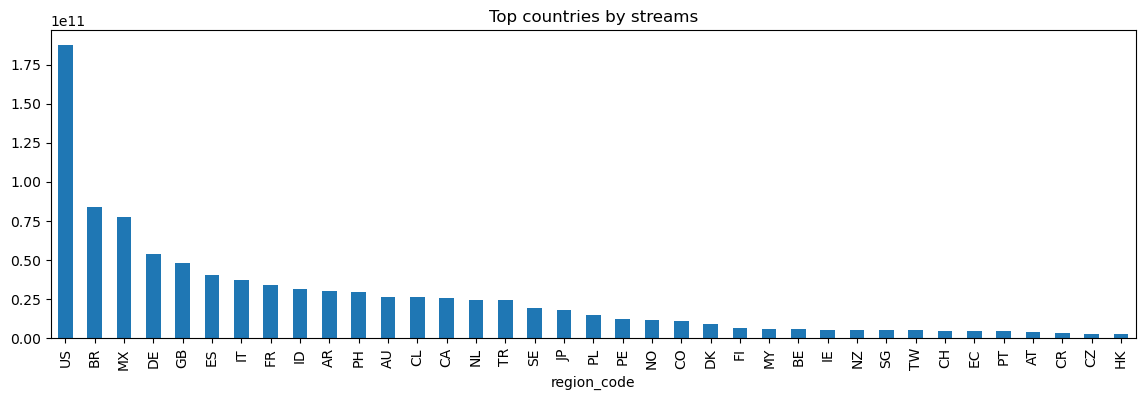

In [123]:
streams_by_region = country_charts.groupby("region_code").streams.sum()
streams_by_country = streams_by_region[streams_by_region.index != "ww"].sort_values(
    ascending=False
)

streams_by_country.sort_values(ascending=False).plot(
    kind="bar", figsize=(14, 4), title=f"Top countries by streams"
)

#### Estimating markets where Spotify is most popular

Probably it is smarter to identify "important" markets by putting the number of total streams in relation to the total population of each country. Unfortunately, no data is available for 2022 yet (as of June 21st, 2023). So, I use the data from the year 2021.

In [124]:
population = pd.read_csv(create_data_path("country_population.csv"), skiprows=3)[
    ["Country Code", "2021"]
].rename(columns={"Country Code": "alpha3", "2021": "population"})
population.head()

,alpha3,population
0,ABW,106537.0
1,AFE,702976832.0
2,AFG,40099462.0
3,AFW,478185907.0
4,AGO,34503774.0


In [125]:
country_codes = pd.read_csv(create_data_path("country_codes.csv"))[
    ["alpha-3", "alpha-2"]
].rename(columns={"alpha-3": "alpha3", "alpha-2": "alpha2"})
country_codes.head()

,alpha3,alpha2
0,AFG,AF
1,ALA,AX
2,ALB,AL
3,DZA,DZ
4,ASM,AS


In [126]:
country_population = pd.merge(country_codes, population, on='alpha3')
country_population.head()

,alpha3,alpha2,population
0,AFG,AF,40099462.0
1,ALB,AL,2811666.0
2,DZA,DZ,44177969.0
3,ASM,AS,45035.0
4,AND,AD,79034.0


In [127]:
streams_by_region.head()

region_code
AR    29991337600
AT     3740452452
AU    26628983129
BE     5579066997
BR    83750767455
Name: streams, dtype: int64

In [128]:
region_names_and_codes = pd.read_csv(create_data_path("region_names_and_codes.csv"))[
    ["name", "code"]
].rename(columns={"code": "alpha2", "name": "region"})
region_names_and_codes.alpha2 = (
    region_names_and_codes.alpha2.str.upper()
)  # convert to uppercase to match existing data
region_names_and_codes.head()

,region,alpha2
0,Global,WW
1,Argentina,AR
2,Australia,AU
3,Austria,AT
4,Belarus,BY


In [129]:
len(region_names_and_codes[region_names_and_codes.alpha2.isin(countries_to_keep)]) == len(countries_to_keep)

True

In [130]:
population_and_streams = pd.merge(
    country_population,
    streams_by_country,
    left_on="alpha2",
    right_index=True,
    how="right",
).reset_index(drop=True)

In [131]:
population_and_streams.head()

,alpha3,alpha2,population,streams
0,USA,US,331893745.0,187566267362
1,BRA,BR,214326223.0,83750767455
2,MEX,MX,126705138.0,77219794766
3,DEU,DE,83196078.0,53583751297
4,GBR,GB,67326569.0,48165879307


In [132]:
len(population_and_streams)

37

In [133]:
population_and_streams[population_and_streams.population.isna()]

,alpha3,alpha2,population,streams
29,NaN,TW,NaN,4978737257


No data seems to be available for Taiwan (code `TW`). I looked up the data manually [here](https://www.census.gov/data-tools/demo/idb/#/country?COUNTRY_YEAR=2021&COUNTRY_YR_ANIM=2021&FIPS_SINGLE=TW). So let's just use that number (23,572,052).

In [134]:
population_and_streams.loc[population_and_streams.alpha2 == 'TW', 'population'] = 23572052

In [135]:
len(population_and_streams) == len(countries_to_keep)

True

In [136]:
population_and_streams = pd.merge(region_names_and_codes, population_and_streams, on='alpha2').rename(columns={'region': 'country'})
population_and_streams.head()

,country,alpha2,alpha3,population,streams
0,Argentina,AR,ARG,45808747.0,29991337600
1,Australia,AU,AUS,25688079.0,26628983129
2,Austria,AT,AUT,8955797.0,3740452452
3,Belgium,BE,BEL,11592952.0,5579066997
4,Brazil,BR,BRA,214326223.0,83750767455


In [137]:
population_and_streams['streams_vs_pop'] = population_and_streams.streams / population_and_streams.population

In [138]:
population_and_streams.head()

,country,alpha2,alpha3,population,streams,streams_vs_pop
0,Argentina,AR,ARG,45808747.0,29991337600,654.707661
1,Australia,AU,AUS,25688079.0,26628983129,1036.628046
2,Austria,AT,AUT,8955797.0,3740452452,417.657128
3,Belgium,BE,BEL,11592952.0,5579066997,481.246450
4,Brazil,BR,BRA,214326223.0,83750767455,390.763045


<Axes: title={'center': 'Top countries (ratio of total streams of chart tracks to population)'}, xlabel='country'>

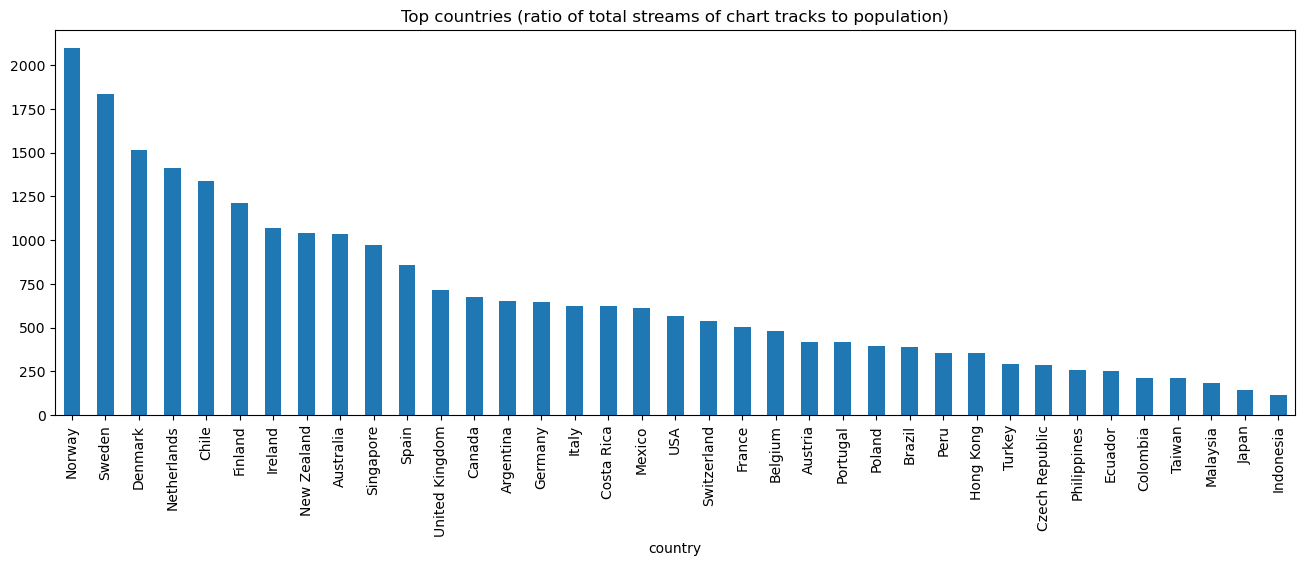

In [139]:
population_and_streams.set_index('country').streams_vs_pop.sort_values(ascending=False).plot(kind='bar', figsize=(16, 5), title=f'Top countries (ratio of total streams of chart tracks to population)')

This ratio between total Spotify streams and total population for a given country might not be the best metric for 'popularity', but it does produce interesting insights. 

We notice that the ratio of Spotify streams (compared to the total population) is biggest in Norway. The number is also quite big for Sweden (Spotify's 'country of origin') and Denmark. The popularity of Spotify in Chile is certainly surprising.

#### Estimating most 'financially relevant' markets

Of course, smaller markets (like Austria with only around 9 mio. total population) are much less relevant for Spotify in terms of number of paying customers and therefore income compared to bigger countries (like the US with its more than 300 mio. inhabitants). So, let's try to find a metric for measuring 'financial relevance' of a particular market/country.

Let's assume that the total number of streams of Top 200 tracks also correlates with the overall popularity of Spotify for any given country.

Then, we can just use the ratio of total streams and population for each country that we already calculated above and multiply it with the population of each country. If we assume that more streams also means more money for Spotify, this would give us a rough idea of the relevance of this country for Spotify.

In [140]:
population_and_streams['financial_relevance'] = population_and_streams.streams_vs_pop * population_and_streams.population
population_and_streams.financial_relevance = population_and_streams.financial_relevance / population_and_streams.financial_relevance.max()

<Axes: title={'center': "Top countries by estimated 'financial relevance', i.e. (total streams of chart tracks / population) * population, normalized by max"}, xlabel='country'>

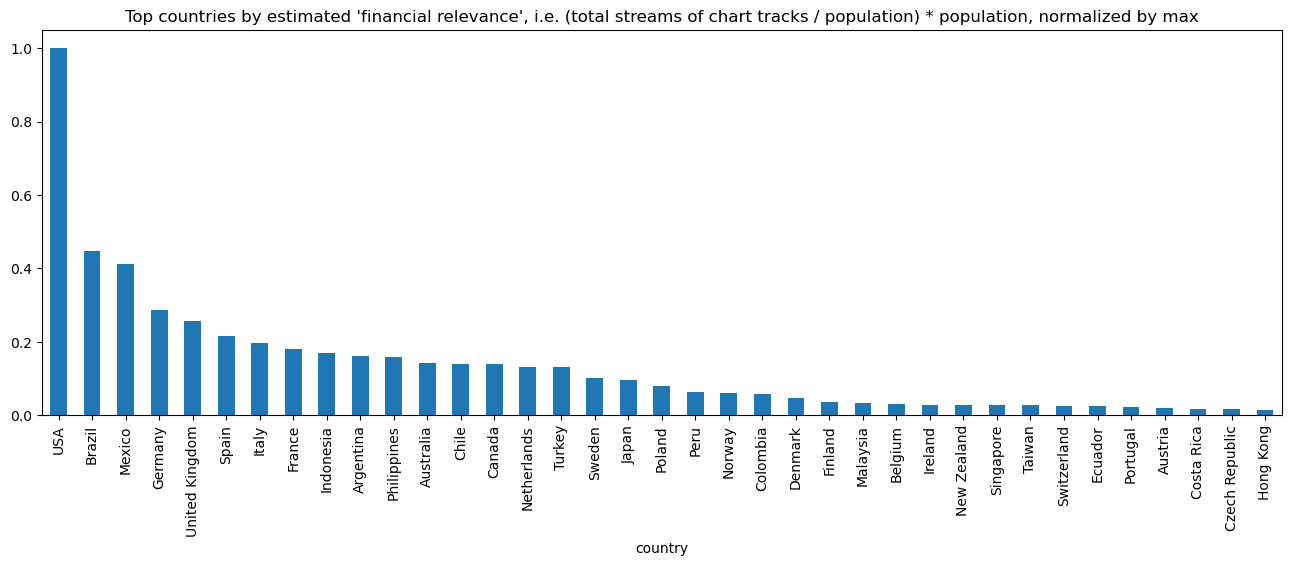

In [141]:
population_and_streams.set_index("country").financial_relevance.sort_values(
    ascending=False
).plot(
    kind="bar",
    figsize=(16, 5),
    title=f"Top countries by estimated 'financial relevance', i.e. (total streams of chart tracks / population) * population, normalized by max",
)

Here, the US again appear as most relevant! There's one more caveat though: some countries (like India) have significantly lower GDP compared to first world countries. Furthermore, it makes a difference what percentage of customers pays for Spotify Premium AND how much Spotify Premium costs in that particular country.

So, this metric is maybe not really that suitable for estimating financial relevance. But still, it might give us a rough idea of where Spotify is 'biggest' (in terms of total number of people using the service).